In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import time
import copy
import numpy as np


In [2]:
def evaluate_model(model, test_loader, device, criterion=None):

    model.eval()
    model.to(device)

    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0

        # statistics
        running_loss += loss * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)

    return eval_loss, eval_accuracy


In [3]:
def train_model(model,
                train_loader,
                test_loader,
                device,
                learning_rate=1e-1,
                num_epochs=200):

    criterion = nn.CrossEntropyLoss()

    model.to(device)

    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate,
                          momentum=0.9,
                          weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[100, 150],
                                                     gamma=0.1,
                                                     last_epoch=-1)

    # Evaluation
    model.eval()
    eval_loss, eval_accuracy = evaluate_model(model=model,
                                              test_loader=test_loader,
                                              device=device,
                                              criterion=criterion)
    print("Epoch: {:03d} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(
        0, eval_loss, eval_accuracy))

    for epoch in range(num_epochs):

        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        for inputs, labels in train_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        # Evaluation
        model.eval()
        eval_loss, eval_accuracy = evaluate_model(model=model,
                                                  test_loader=test_loader,
                                                  device=device,
                                                  criterion=criterion)

        scheduler.step()

        print(
            "Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}"
            .format(epoch + 1, train_loss, train_accuracy, eval_loss,
                    eval_accuracy))

    return model


In [4]:
class Quantized(nn.Module):
    def __init__(self, model_fp32):

        super(Quantized, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model_fp32 = model_fp32


    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [5]:
def model_equivalence(model_1,
                      model_2,
                      device,
                      rtol=1e-05,
                      atol=1e-08,
                      num_tests=100,
                      input_size=(1, 3, 32, 32)):

    model_1.to(device)
    model_2.to(device)

    for _ in range(num_tests):
        x = torch.rand(size=input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        if np.allclose(a=y1, b=y2, rtol=rtol, atol=atol,
                       equal_nan=False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False

    return True

In [6]:
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Resize to 32x32
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize: mean and std for RGB channels
])

batch_size = 200

# Get dataset class object corresponding to train split
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create data loader from train dataset object
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Get dataset class object corresponding to test split
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loader from test dataset object
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Define the classes for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:19<00:00, 8903163.90it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
from torch.utils.data import Subset
indices = torch.arange(0, 500)
test_subset = Subset(testset, indices)
small_test_loader = torch.utils.data.DataLoader(test_subset, batch_size=50,
                                          shuffle=True, num_workers=2)

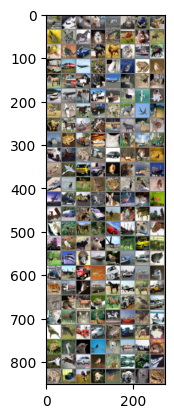

deer  ship  dog   horse deer  cat   automobile frog  frog  cat   horse dog   frog  airplane cat   deer  frog  cat   automobile horse deer  cat   ship  horse truck truck airplane frog  cat   ship  frog  bird  horse truck truck cat   airplane cat   cat   cat   automobile airplane dog   truck ship  deer  airplane dog   airplane airplane horse automobile frog  dog   airplane cat   frog  horse deer  deer  deer  deer  dog   dog   ship  frog  truck ship  cat   deer  ship  truck truck horse frog  truck automobile deer  cat   deer  deer  airplane truck automobile dog   dog   airplane ship  airplane deer  deer  bird  frog  deer  bird  cat   airplane truck truck frog  dog   deer  cat   frog  truck truck frog  automobile bird  frog  deer  truck cat   frog  horse bird  automobile ship  dog   horse truck bird  deer  cat   airplane deer  automobile deer  deer  ship  bird  ship  bird  ship  automobile frog  truck bird  truck frog  automobile automobile airplane bird  horse truck cat   automobile horse

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [10]:
def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model

In [11]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

model = VGG16(num_classes=10)

model = train_model(model=model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        device=cuda_device,
                        learning_rate=1e-1,
                        num_epochs=5)

Epoch: 000 Eval Loss: 2.303 Eval Acc: 0.100
Epoch: 001 Train Loss: 1.712 Train Acc: 0.338 Eval Loss: 1.475 Eval Acc: 0.443
Epoch: 002 Train Loss: 1.219 Train Acc: 0.565 Eval Loss: 1.111 Eval Acc: 0.600
Epoch: 003 Train Loss: 0.928 Train Acc: 0.678 Eval Loss: 0.926 Eval Acc: 0.685
Epoch: 004 Train Loss: 0.733 Train Acc: 0.749 Eval Loss: 0.798 Eval Acc: 0.742
Epoch: 005 Train Loss: 0.597 Train Acc: 0.799 Eval Loss: 0.755 Eval Acc: 0.756


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
model_dir = "/content/drive/MyDrive/vision lab/qat/"
model_filename = "VGG16.pth"
model_filepath = model_dir + model_filename

save_model(model=model, model_dir=model_dir, model_filename=model_filename)

# Load a pretrained model.
model = load_model(model=model,
                   model_filepath=model_filepath,
                   device=cuda_device)

# Move the model to CPU since static quantization does not support CUDA currently.
model.to(cpu_device)
# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)

model.eval()
# The model has to be switched to eval mode before any layer fusion.
# Otherwise the quantization aware training will not work.
fused_model.eval()

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [24]:
def fuse_vgg16_model(model): #this fuction should be changedd according to the model
    fused_model = model
    # Iterate through the feature layers and fuse conv, bn, and relu layers
    for module_name, module in fused_model.named_children():
        if module_name == "features":
            for idx, layer in enumerate(module):
                if isinstance(layer, nn.Conv2d):
                    next1 = module[idx + 1] if idx + 1 < len(module) else None
                    next2 = module[idx + 2] if idx + 2 < len(module) else None
                    if isinstance(next1, nn.BatchNorm2d) and isinstance(next2, nn.ReLU):
                        torch.quantization.fuse_modules(
                            module, [str(idx), str(idx + 1), str(idx + 2)], inplace=True
                        )
    return fused_model

fused_model = fuse_vgg16_model(model)

In [25]:
assert model_equivalence(
        model_1=model,
        model_2=fused_model,
        device=cpu_device,
        rtol=1e-03,
        atol=1e-06,
        num_tests=100,
        input_size=(
            1, 3, 32,
            32)), "Fused model is not equivalent to the original model!"

In [26]:
qat_model = Quantized(model_fp32=fused_model)
backend = "qnnpack"
torch.backends.quantized.engine = backend

qat_model.qconfig = torch.quantization.get_default_qat_qconfig(backend)
qat_model = torch.quantization.prepare_qat(qat_model, inplace=False)

print("Training QAT Model...")
qat_model.train()
train_model(model=qat_model,
            train_loader=train_loader,
            test_loader=test_loader,
            device=cuda_device,
            learning_rate=1e-3,
            num_epochs=2)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Training QAT Model...


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:71.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 000 Eval Loss: 0.756 Eval Acc: 0.755
Epoch: 001 Train Loss: 0.402 Train Acc: 0.864 Eval Loss: 0.521 Eval Acc: 0.832
Epoch: 002 Train Loss: 0.362 Train Acc: 0.877 Eval Loss: 0.506 Eval Acc: 0.837


Quantized(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([0.0078], device='cuda:0'), zero_point=tensor([127], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=255, qscheme=torch.per_tensor_affine, reduce_range=False
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.0, max_val=1.0)
    )
  )
  (dequant): DeQuantStub()
  (model_fp32): VGG16(
    (features): Sequential(
      (0): ConvReLU2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (weight_fake_quant): PerChannelMinMaxObserver(
          min_val=tensor([-1.6155, -0.9982, -0.2290, -1.2310, -1.0636, -1.3091, -0.7082, -1.2192,
                  -0.6299, -1.0191, -1.4117, -0.6009, -1.1463, -2.4115, -0.5967, -0.5455,
                  -0.7814, -2.2419, -0.3877, -0.7518, -0.3996, -0.4519, -0.1973, -0.9905,
   

In [55]:
backend = "x86"
torch.backends.quantized.engine = backend

ptq_model = fused_model
ptq_model.qconfig = torch.quantization.get_default_qconfig(backend)
ptq_model = torch.quantization.prepare(ptq_model, inplace=False)

In [56]:
def save_torchscript_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.jit.save(torch.jit.script(model), model_filepath)


def load_torchscript_model(model_filepath, device):

    model = torch.jit.load(model_filepath, map_location=device)

    return model


In [57]:
ptq_model.to(cpu_device)
ptq_model = torch.ao.quantization.convert(ptq_model, inplace=False)
ptq_model.eval()

qat_model.to(cpu_device)
qat_model = torch.ao.quantization.convert(qat_model, inplace=False)
qat_model.eval()

print("QAT model")
print(qat_model)

print("PTQ model")
print(ptq_model)

QAT model
Quantized(
  (quant): Quantize(scale=tensor([0.0078]), zero_point=tensor([127]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): VGG16(
    (features): Sequential(
      (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.05761462077498436, zero_point=0, padding=(1, 1))
      (1): Identity()
      (2): Identity()
      (3): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.06250809133052826, zero_point=0, padding=(1, 1))
      (4): Identity()
      (5): Identity()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.03699629008769989, zero_point=0, padding=(1, 1))
      (8): Identity()
      (9): Identity()
      (10): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.049747928977012634, zero_point=0, padding=(1, 1))
      (11): Identity()
      (12): Identity()
      (13): MaxPool2

In [58]:
qat_quantized_model_filename = "qat.pth"
ptq_quantized_model_filename = "ptq.pth"
save_torchscript_model(model=qat_model,
                           model_dir=model_dir,
                           model_filename=qat_quantized_model_filename)
save_torchscript_model(model=ptq_model,
                           model_dir=model_dir,
                           model_filename=ptq_quantized_model_filename)

In [59]:
# Load quantized model.
quantized_model_filepath = "/content/drive/MyDrive/vision lab/qat/qat.pth"
loaded_qat_model = load_torchscript_model(
    model_filepath=quantized_model_filepath, device=cpu_device)

quantized_model_filepath = "/content/drive/MyDrive/vision lab/qat/ptq.pth"
loaded_ptq_model = load_torchscript_model(
    model_filepath=quantized_model_filepath, device=cpu_device)

In [60]:
_, int8_eval_accuracy_qat = evaluate_model(model=loaded_qat_model,
                                       test_loader=small_test_loader,
                                       device=cpu_device,
                                       criterion=nn.CrossEntropyLoss())

In [61]:
_, int8_eval_accuracy_ptq = evaluate_model(model=loaded_ptq_model,
                                       test_loader=small_test_loader,
                                       device=cpu_device,
                                       criterion=nn.CrossEntropyLoss())

NotImplementedError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__.py", line 12, in forward
    x: Tensor) -> Tensor:
    features = self.features
    x0 = (features).forward(x, )
          ~~~~~~~~~~~~~~~~~ <--- HERE
    avgpool = self.avgpool
    x1 = (avgpool).forward(x0, )
  File "code/__torch__/torch/nn/modules/container.py", line 76, in forward
    _32 = getattr(self, "32")
    _33 = getattr(self, "33")
    input0 = (_0).forward(input, )
              ~~~~~~~~~~~ <--- HERE
    input1 = (_1).forward(input0, )
    input2 = (_2).forward(input1, )
  File "code/__torch__/torch/ao/nn/intrinsic/quantized/modules/conv_relu.py", line 41, in forward
    scale = self.scale
    zero_point = self.zero_point
    _5 = ops.quantized.conv2d_relu(input0, _packed_params, scale, zero_point)
         ~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    return _5
  def __getstate__(self: __torch__.torch.ao.nn.intrinsic.quantized.modules.conv_relu.ConvReLU2d) -> Tuple[int, int, Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int], bool, Tuple[int, int], int, str, Tensor, Optional[Tensor], float, int, bool]:

Traceback of TorchScript, original code (most recent call last):
  File "<ipython-input-9-a2ab96d0fe08>", line 60, in forward
    def forward(self, x):
        x = self.features(x)
            ~~~~~~~~~~~~~ <--- HERE
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py", line 217, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/usr/local/lib/python3.10/dist-packages/torch/ao/nn/intrinsic/quantized/modules/conv_relu.py", line 99, in forward
            input = F.pad(input, _reversed_padding_repeated_twice,
                          mode=self.padding_mode)
        return torch.ops.quantized.conv2d_relu(
               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            input, self._packed_params, self.scale, self.zero_point)
RuntimeError: Could not run 'quantized::conv2d_relu.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d_relu.new' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at ../aten/src/ATen/native/quantized/cpu/qconv.cpp:1928 [kernel]
QuantizedCUDA: registered at ../aten/src/ATen/native/quantized/cudnn/Conv.cpp:391 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:202 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]



In [62]:
print(int8_eval_accuracy_qat)

tensor(0.8340)
